<a href="https://colab.research.google.com/github/parthkohli92/Tensorflow/blob/main/TransferLearning_FeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning With Feature Extraction

In [1]:
# Using A GPU 
!nvidia-smi

Thu Oct 21 16:17:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

1. Downloading the data 

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-10-21 16:17:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   144MB/s    in 1.1s    

2021-10-21 16:17:06 (144 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os 

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

2. Creating data loaders(preparing the data)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE= 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [5]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using Tensorflow Hub

We are going to use 2 Tensorflow Models:

1. ResNetV2
2. EfficientNet

In [7]:
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras import layers 

In [8]:
# Efficient Net B0 feature vector 
effnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

# ResNet 50 V2
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

Since we're going to be comparing 2 models, to save ourselves code, we'll create a function create_model()

In [12]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))
  
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name='output_layer')
  ])

  return model

In [15]:
# Create model 
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile 
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [16]:
# Fit the model 
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20211021-175350

Got `type(handle)`: <class 'keras.engine.sequential.Sequential'>



Got `type(handle)`: <class 'keras.engine.sequential.Sequential'>


Epoch 1/5
24/24 [==============================] - 60s 1s/step - loss: 2.3064 - accuracy: 0.0813 - val_loss: 2.3100 - val_accuracy: 0.0856
Epoch 2/5
24/24 [==============================] - 22s 941ms/step - loss: 2.3031 - accuracy: 0.0907 - val_loss: 2.3068 - val_accuracy: 0.0904
Epoch 3/5
24/24 [==============================] - 22s 928ms/step - loss: 2.2999 - accuracy: 0.1053 - val_loss: 2.3039 - val_accuracy: 0.0964
Epoch 4/5
24/24 [==============================] - 22s 932ms/step - loss: 2.2969 - accuracy: 0.1173 - val_loss: 2.3010 - val_accuracy: 0.1016
Epoch 5/5
24/24 [==============================] - 22s 928ms/step - loss: 2.2939 - accuracy: 0.1213 - val_loss: 2.2981 - val_accuracy: 0.1116


In [17]:
import matplotlib.pyplot as plt 

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

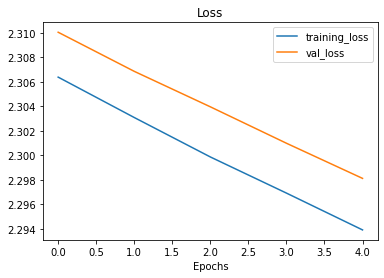

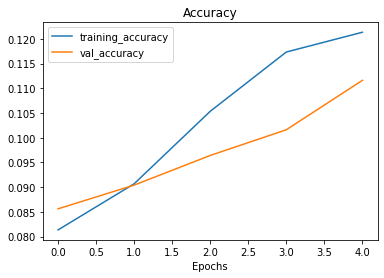

In [18]:
plot_loss_curves(resnet_history)

In [19]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 10)                23585290  
_________________________________________________________________
output_layer (Dense)         (None, 10)                110       
Total params: 23,585,400
Trainable params: 110
Non-trainable params: 23,585,290
_________________________________________________________________


The feature extraction layer has 23,585,290 parameters which are prelearned patterns the model has already learned on the ImageNet dataset.
Since we set trainable = False, these patterns remain frozen(non trainable) during training.


This means during training the model updates the 20,490 parameters in the  output layers to suit our dataset.

Okay so we've trained a ResnetV2 model, now we'll move on to the efficientNetB0 model.

In [27]:
# Create Model
efficient_model = create_model(effnet_url, num_classes=train_data_10_percent.num_classes)

# Compile 
efficient_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

# Fit the model 
efficient_history = efficient_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="effNetB0")])


Saving TensorBoard log files to: tensorflow_hub/effNetB0/20211021-182618
Epoch 1/5
24/24 [==============================] - 27s 944ms/step - loss: 1.8246 - accuracy: 0.4400 - val_loss: 1.2748 - val_accuracy: 0.7284
Epoch 2/5
24/24 [==============================] - 19s 800ms/step - loss: 1.0552 - accuracy: 0.7707 - val_loss: 0.8663 - val_accuracy: 0.8112
Epoch 3/5
24/24 [==============================] - 18s 791ms/step - loss: 0.7587 - accuracy: 0.8280 - val_loss: 0.7018 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 19s 795ms/step - loss: 0.6099 - accuracy: 0.8653 - val_loss: 0.6145 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 18s 788ms/step - loss: 0.5161 - accuracy: 0.8880 - val_loss: 0.5623 - val_accuracy: 0.8604


Damn! The efficientNetB0 model does it even better than ResNetV2 model, achieving over 85% accuracy on the test set...with only 10% of the training data

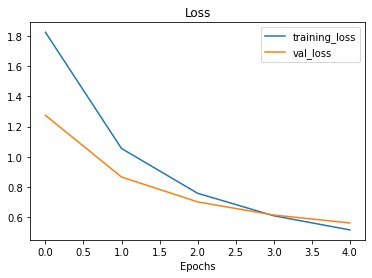

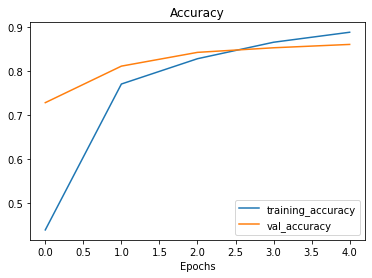

In [28]:
plot_loss_curves(efficient_history
                 )

In [29]:
efficient_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
